# Tracking Titanic experiment using MLCenter

**Imports**

In [32]:
import os
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics, model_selection, preprocessing, ensemble, compose, pipeline, impute

plt.style.use('ggplot')

**Load Data**

In [2]:
DATSET_URL = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'

In [4]:
data = pd.read_csv(DATSET_URL)
data.columns = data.columns.str.lower()
data[:3]

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


**Set features and target**

In [11]:
SEED = 42
FEATURES = ['pclass', 'sex', 'age']
NUMERICAL = ['age']
CATEGORICAL = ['pclass', 'sex']
TARGET = 'survived'

**Create model pipeline**

In [8]:
categorical_transformer = preprocessing.OneHotEncoder(handle_unknown='ignore')
numerical_transformer = pipeline.Pipeline([
    ('imputer', impute.SimpleImputer(strategy='median')),
    ('scaler', preprocessing.StandardScaler())
])

In [9]:
processor = compose.ColumnTransformer([
    ('num', numerical_transformer, NUMERICAL),
    ('cat', categorical_transformer, CATEGORICAL)
])

In [15]:
MODEL_HYPERPARAMETERS = {
    'random_state': SEED,
    'n_estimators': 300,
    'n_jobs': -1
}

In [16]:
model = pipeline.Pipeline([
    ('processor', processor),
    ('classifier', ensemble.RandomForestClassifier(**MODEL_HYPERPARAMETERS))
])

In [12]:
train, test  = model_selection.train_test_split(data, test_size=0.2, random_state=SEED, stratify=data[TARGET])

In [17]:
model.fit(train[FEATURES], train[TARGET])

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['pclass', 'sex'])])),
                ('classifier',
                 RandomForestClassifier(n_estimators=300, n_jobs=-1,
                                        random_state=42))])

**Assess model performance**

In [18]:
results = pd.DataFrame({
    'y_true': test[TARGET].values,
    'y_pred': model.predict(test[FEATURES])
})
results[:3]

,y_true,y_pred
0,0,0
1,0,0
2,1,0


In [24]:
metrics_dict = {
    'accuracy': metrics.accuracy_score(results['y_true'], results['y_pred']),
    'balanced_accuracy': metrics.balanced_accuracy_score(results['y_true'], results['y_pred']),
    'precision': metrics.precision_score(results['y_true'], results['y_pred']),
    'recall': metrics.recall_score(results['y_true'], results['y_pred']),
}
metrics_dict

{'accuracy': 0.8100558659217877,
 'balanced_accuracy': 0.7914361001317523,
 'precision': 0.7777777777777778,
 'recall': 0.7101449275362319}

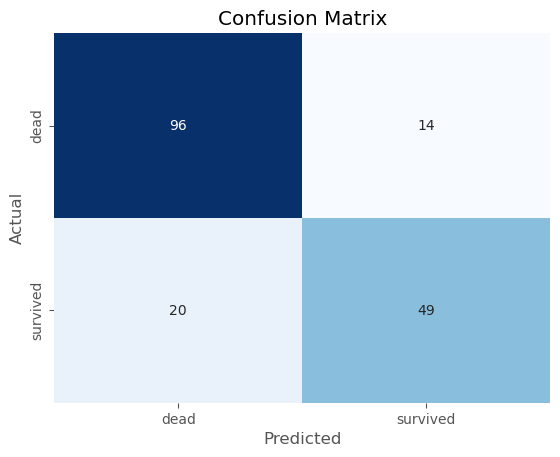

In [29]:
confusion_matrix = pd.DataFrame(metrics.confusion_matrix(results['y_true'], results['y_pred']), columns=['dead', 'survived'], index=['dead', 'survived'])
fig = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
fig;

**Save model**

In [31]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

## MLCenter

**Initialize the client**


In [ ]:
from mlcenter import MLCenter

center = MLCenter(
    
    # These variables are optionoal, and if not provided, will be taken from the environment variables
    ####################################
    MLCENTER_URL='http://localhost:8000',
    MLCENTER_USERNAME='daniel.fat',
    MLCENTER_PASSWORD='test!2345',
    ####################################
    
    # Project ID is required and you can get the id from the project created in the MLCenter UI
    PROJECT_ID='05a87a0d-6ca0-40a2-90df-9386d2fcc5a2',
    )

## Creating an experiment 

**Create experiment**

In [ ]:
center.create_experiment(
    name='Titanic',
    description='Titanic experiment',
    experiment_tags='Titanic, Kaggle, ML, MLCenter',
    tags=['Titanic', 'Kaggle', 'ML', 'MLCenter'],
    experiment_metrics=metrics_dict,
    experiment_hyperparameters=MODEL_HYPERPARAMETERS,
    # omiting this step for now
    experiment_requirements={}
    )

**Log Artifacts**

In [ ]:
center.log_artifact(artifact_path='model.pkl')
center.log_artifact(artifact_path='confusion_matrix.png')

## Loading Experiment Artifacts

In [33]:
DOWNLOAD_PATH = './artifacts'
os.makedirs(DOWNLOAD_PATH, exist_ok=True)

In [ ]:
conf_mx_path = center.download_artifacts(download_path=DOWNLOAD_PATH, artifact_name='confusion_matrix.png', model_name='Titanic', model_stage='DEV')

In [ ]:
os.remove(os.path.join(DOWNLOAD_PATH, 'confusion_matrix.png'))

In [ ]:
artifacts_path = center.sync_artifacts(download_path=DOWNLOAD_PATH, model_name='Titanic', model_stage='DEV')

Thank you for going through this tutorial. We hope you enjoyed it and learned something new. 

If you have any questions or suggestions, please feel free to reach out to us at on discord or by email, links on MLCenter website. [MLCenter](https://mlcenter.org)